I am practicing the exercise from this [link](https://www.learnpytorch.io/03_pytorch_computer_vision/#exercises)

In [1]:
# check for gpu
!nvidia-smi

Mon Feb 10 22:13:02 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0  On |                  N/A |
| N/A   38C    P8              N/A / ERR! |     47MiB /  4096MiB |     32%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

print(torch.__version__)

2.5.1


In [3]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device


'cuda'

## Load the torchvision.datasets.MNIST() train and test datasets.

In [4]:
from torchvision import datasets
from torchvision import transforms

# Get the MNIST train dataset
train_data = datasets.MNIST(root='data', 
                            train=True, 
                            download=True, 
                            transform=transforms.ToTensor(), 
                            target_transform=None)
# Get the MNIST test dataset
test_data = datasets.MNIST(root='data', 
                           train=False, 
                           download=True, 
                           transform=transforms.ToTensor(), 
                           target_transform=None)

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
# See the image shape and label of the data
image, label = train_data[0]

print(f"Image Shape: {image.shape}\n")
print(f"Label: {label}")

Image Shape: torch.Size([1, 28, 28])

Label: 5


In [7]:
# Get the class name
class_names = train_data.classes
print(f'Class Names: {class_names}\n')

# Get the labels idx
class_names_idx = train_data.class_to_idx
print(f"Index of the labels:\n {class_names_idx}")

Class Names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Index of the labels:
 {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


## Visualize at least 9 different samples of the MNIST training dataset.

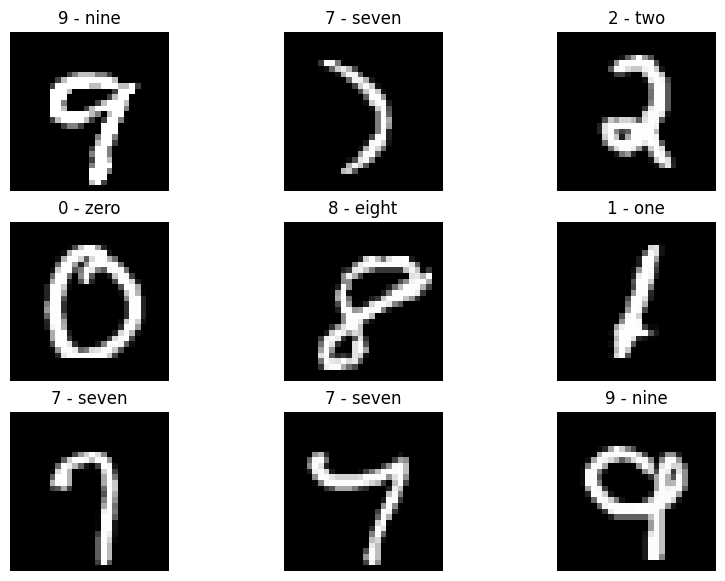

In [8]:
import matplotlib.pyplot as plt

nrows = 3
ncols = 3
fig = plt.figure(figsize=(10,7))
for i in range(1,nrows*ncols+1):
    # set random image
    random_idx = torch.randint(low=0, high=len(train_data), size=[1]).item()
    fig.add_subplot(nrows, ncols, i)
    img, label = train_data[random_idx]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)
plt.show() 


## Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [9]:
from torch.utils.data import DataLoader

# Set the batch sizes 32 (i.e. in one batch we have 32 images)
BATCH_SIZES = 32

# Create train dataloader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZES, 
                              shuffle=True)
# Create test dataloader
test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZES, 
                             shuffle=False)

# see what we have created
print(f"Length of train dataloaders: {len(train_dataloader)} batchs of {BATCH_SIZES}")
print(f"Length of test dataloaders: {len(test_dataloader)} batchs of {BATCH_SIZES}")

Length of train dataloaders: 1875 batchs of 32
Length of test dataloaders: 313 batchs of 32


## Recreate model_2 used in notebook 03 (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [10]:
from torch import nn
class MNISTMODELV1(nn.Module):
    """Model that capable of predicting MNIST dataset
    """

    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit*7*7, out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        # print(f"after conv block 1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"after conv block 2: {x.shape}")
        x = self.classifier(x)
        # print(f"after classifier: {x.shape}")
        return x

        
# create model instance and target to device
model_1 = MNISTMODELV1(input_shape=1, 
                       hidden_unit=10, 
                       output_shape=len(class_names)).to(device)


In [13]:
%%time
from tqdm.auto import tqdm 

# Train on CPU
model_cpu = MNISTMODELV1(input_shape=1,
                        hidden_unit=10,
                        output_shape=10).to("cpu")

# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cpu.parameters(), lr=0.1)

### Training loop
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_cpu.train()

    # Put data on CPU
    X, y = X.to("cpu"), y.to("cpu")

    # Forward pass
    y_pred = model_cpu(X)

    # Loss calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Step the optimizer
    optimizer.step()
  
  # Adjust train loss for number of batches
  train_loss /= len(train_dataloader)

  ### Testing loop
  test_loss_total = 0

  # Put model in eval mode 
  model_cpu.eval()

  # Turn on inference mode
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      # Make sure test data on CPU
      X_test, y_test = X_test.to("cpu"), y_test.to("cpu")
      test_pred = model_cpu(X_test)
      test_loss = loss_fn(test_pred, y_test)

      test_loss_total += test_loss
    
    test_loss_total /= len(test_dataloader)
  
  # Print out what's happening
  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.331 | Test loss: 0.083
Epoch: 1 | Loss: 0.072 | Test loss: 0.065
Epoch: 2 | Loss: 0.056 | Test loss: 0.044
Epoch: 3 | Loss: 0.048 | Test loss: 0.045
Epoch: 4 | Loss: 0.043 | Test loss: 0.041
CPU times: user 5min 52s, sys: 1.08 s, total: 5min 53s
Wall time: 1min 28s


In [15]:
%%time
from tqdm.auto import tqdm 

device = "cuda" if torch.cuda.is_available() else "cpu"

# Train on GPU
model_gpu = MNISTMODELV1(input_shape=1,
                        hidden_unit=10,
                        output_shape=10).to(device)

# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_gpu.parameters(), lr=0.1)

# Training loop
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss = 0
  model_gpu.train()
  for batch, (X, y) in enumerate(train_dataloader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model_gpu(X)

    # Loss calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Step the optimizer
    optimizer.step()
  
  # Adjust train loss to number of batches
  train_loss /= len(train_dataloader)

  ### Testing loop
  test_loss_total = 0
  # Put model in eval mode and turn on inference mode
  model_gpu.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      # Make sure test data on target device
      X_test, y_test = X_test.to(device), y_test.to(device)
      
      test_pred = model_gpu(X_test)
      test_loss = loss_fn(test_pred, y_test)

      test_loss_total += test_loss

    # Adjust test loss total for number of batches
    test_loss_total /= len(test_dataloader)
  
  # Print out what's happening
  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.308 | Test loss: 0.067
Epoch: 1 | Loss: 0.077 | Test loss: 0.091
Epoch: 2 | Loss: 0.061 | Test loss: 0.052
Epoch: 3 | Loss: 0.053 | Test loss: 0.057
Epoch: 4 | Loss: 0.046 | Test loss: 0.044
CPU times: user 40.6 s, sys: 144 ms, total: 40.8 s
Wall time: 41.2 s


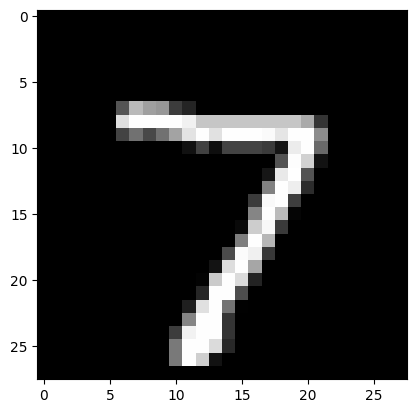

In [16]:
# Make predictions with the trained model
plt.imshow(test_data[0][0].squeeze(), cmap="gray")

In [17]:
# Logits -> Prediction probabilities -> Prediction labels
model_pred_logits = model_gpu(test_data[0][0].unsqueeze(dim=0).to(device)) # make sure image is right shape + on right device
model_pred_probs = torch.softmax(model_pred_logits, dim=1)
model_pred_label = torch.argmax(model_pred_probs, dim=1)
model_pred_label

tensor([7], device='cuda:0')

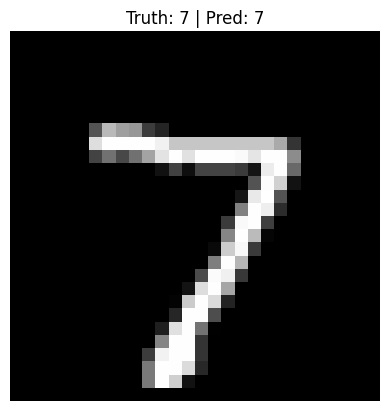

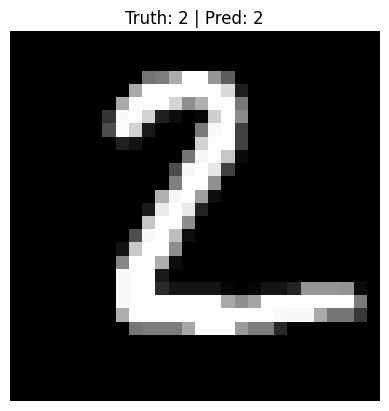

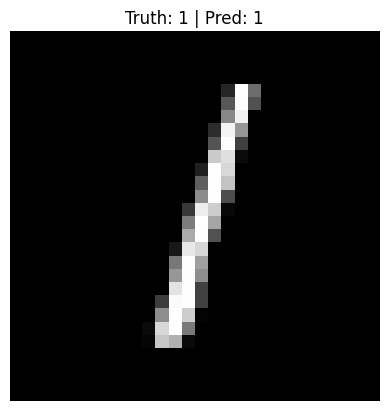

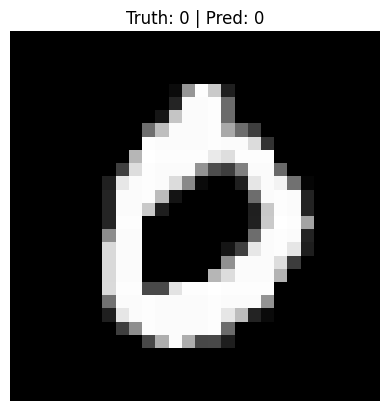

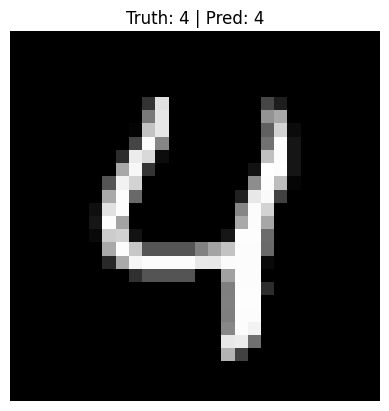

In [18]:
num_to_plot = 5 
for i in range(num_to_plot):
  # Get image and labels from the test data
  img = test_data[i][0]
  label = test_data[i][1]

  # Make prediction on image
  model_pred_logits = model_gpu(img.unsqueeze(dim=0).to(device))
  model_pred_probs = torch.softmax(model_pred_logits, dim=1)
  model_pred_label = torch.argmax(model_pred_probs, dim=1)

  # Plot the image and prediction
  plt.figure()
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Truth: {label} | Pred: {model_pred_label.cpu().item()}") 
  plt.axis(False);
     

In [19]:

# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [20]:
# Make predictions across all test data
from tqdm.auto import tqdm
model_gpu.eval()
y_preds = []
with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    # Make sure data on right device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred_logits = model_gpu(X)
    # Logits -> Pred probs -> Pred label
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    # Append the labels to the preds list
    y_preds.append(y_pred_labels)
  y_preds=torch.cat(y_preds).cpu()
len(y_preds) 

0it [00:00, ?it/s]

10000

In [21]:
test_data.targets[:10], y_preds[:10]


(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

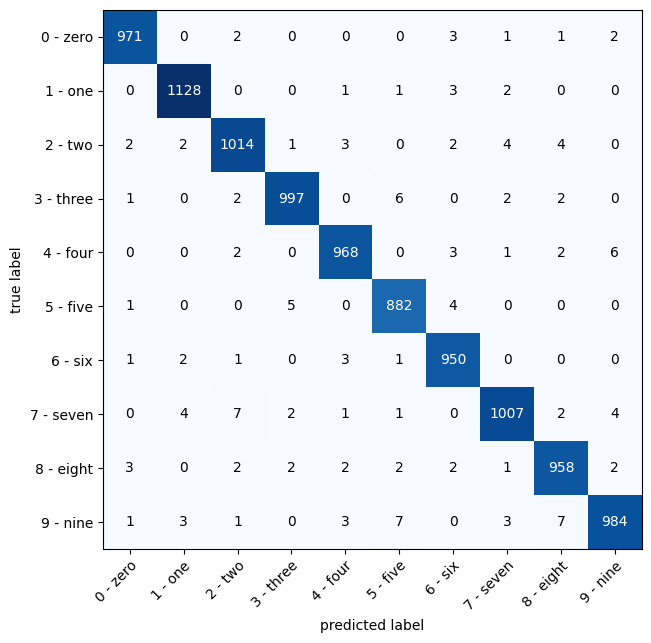

In [22]:

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix 
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)